# Определение факторов успешности игры

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Изучение данных из файлов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math
from functools import reduce

Загрузим данные из исходного файла и изучим их.

In [2]:
df  = pd.read_csv('/datasets/games.csv')

Описание данных
- Name — название игры;
- Platform — платформа;
- Year_of_Release — год выпуска;
- Genre — жанр игры;
- NA_sales — продажи в Северной Америке (миллионы проданных копий);
- EU_sales — продажи в Европе (миллионы проданных копий);
- JP_sales — продажи в Японии (миллионы проданных копий);
- Other_sales — продажи в других странах (миллионы проданных копий);
- Critic_Score — оценка критиков (максимум 100);
- User_Score — оценка пользователей (максимум 10);
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

In [3]:
display(df.sample(10, random_state=1))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
14230,Rakushou! Pachi-Slot Sengen 5: Rio Paradise,PS2,2007.0,Misc,0.00,0.00,0.03,0.00,NaN,NaN,NaN
14043,Nobunaga's Ambition II,3DS,2015.0,Strategy,0.00,0.00,0.04,0.00,NaN,NaN,NaN
3158,Up,DS,2009.0,Action,0.30,0.27,0.00,0.07,NaN,tbd,E
22,Super Mario Bros. 3,NES,1988.0,Platform,9.54,3.44,3.84,0.46,NaN,NaN,NaN
110,Mario Kart 8,WiiU,2014.0,Racing,3.15,2.15,1.28,0.51,88.0,9.1,E
1988,ATV: Quad Power Racing,PS,2000.0,Racing,0.58,0.39,0.00,0.07,42.0,tbd,E
7130,64 de Hakken! Tamagotchi Minna de Tamagotchi W...,N64,1997.0,Misc,0.00,0.00,0.22,0.00,NaN,NaN,NaN
8849,Derby Stallion 64,N64,2001.0,Sports,0.00,0.00,0.15,0.00,NaN,NaN,NaN
14602,Star Wars: The Force Unleashed II,PC,2010.0,Action,0.03,0.00,0.00,0.00,59.0,5.8,T
106,Tekken 3,PS,1998.0,Fighting,3.27,2.22,1.40,0.29,96.0,9.1,T


Встречаются пропуски и непонятные значения, например, "tbd".

Проверим, в каких столбцах есть пропуски и сколько их.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
Name,0.01
Platform,0
Year_of_Release,1.61
Genre,0.01
NA_sales,0
EU_sales,0
JP_sales,0
Other_sales,0
Critic_Score,51.32
User_Score,40.09


Проверим, есть ли дубликаты.

In [6]:
df.duplicated().sum()

0

Дубликаты не найдены.

### Вывод

При изучении файлов были выявлены следующие пункты:
- названия в столбцах необходимо привести к нижнему регистру;
- пропуски в столбцах 'name', 'year_of_release' и 'genre'. Их количество незначительное (менее 2%), влиять на результаты исследования не будут. Но их обработать не получится, т.к. нет алгоритма их получения;
- также есть пропуски в столбцах 'critic_score', 'user_score' и 'rating'. Их количество очень большое (более 40%), поэтому удалить их нельзя и нужно будет сделать замену на уникальное значение;
- в столбце 'user_score' есть значение "tbd". Нужно понять, что это за значение и как его обработать; 
- в столбце 'year_of_release' необходимо изменить тип данных на целочисленный;
- в столбце 'user_score' необходимо изменить тип данных на вещественный;
- повторяющиеся строки не были найдены.

## Предобработка данных

Заменим названия столбцов (приведём к нижнему регистру).

In [7]:
df.columns= df.columns.str.lower()

Преобразуем данные в нужные типы:
- значения 'year_of_release' из вещественного типа данных в целочисленный, т.к. год выпуска должен быть целым числом.

Также заменим пропуски на уникальное значение "-1", заполнить их мы не можем, т.к. у нас нет данных, но и удалить их не будем, т.к. другие столбцы содержат полезную информацию. 

- значения 'user_score' из строки в вещественный тип данных, т.к. рейтинг должен быть дробным числом.

Также заменим tbd и пропуски на уникальное значение "-1" по той же причине.

Поиск в Интернете помог определить, что аббревиатура tbd (to be decided или to be determined) - служит для отметки неясностей или пропусков, которые надо заполнить. Данных с оценками пользователей у нас нет, поэтому заполним пропуски уникальным значением "-1".

In [8]:
df['year_of_release'] = df['year_of_release'].fillna(-1).astype('int')

In [9]:
df['user_score'] = df['user_score'].replace('tbd', -1)
df['user_score'] = df['user_score'].fillna(-1).astype('float')

Заполним пропуски в столбцах 'name' и 'genre' на уникальное значение "нет данных", т.к. их заполнить невозможно.
Пропуски в столбцах 'critic_score' и 'rating' заполним "-1".
Возможные причины пропусков - некорректное заполнение информации либо источники информации разные и при их объединении часть информации потерялась.

In [10]:
df['name'] = df['name'].fillna('нет данных')
df['genre'] = df['genre'].fillna('нет данных')
df['critic_score'] = df['critic_score'].fillna(-1)
df['rating'] = df['rating'].fillna(-1)

In [11]:
display(df.sample(10, random_state=1))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14230,Rakushou! Pachi-Slot Sengen 5: Rio Paradise,PS2,2007,Misc,0.00,0.00,0.03,0.00,-1.0,-1.0,-1
14043,Nobunaga's Ambition II,3DS,2015,Strategy,0.00,0.00,0.04,0.00,-1.0,-1.0,-1
3158,Up,DS,2009,Action,0.30,0.27,0.00,0.07,-1.0,-1.0,E
22,Super Mario Bros. 3,NES,1988,Platform,9.54,3.44,3.84,0.46,-1.0,-1.0,-1
110,Mario Kart 8,WiiU,2014,Racing,3.15,2.15,1.28,0.51,88.0,9.1,E
1988,ATV: Quad Power Racing,PS,2000,Racing,0.58,0.39,0.00,0.07,42.0,-1.0,E
7130,64 de Hakken! Tamagotchi Minna de Tamagotchi W...,N64,1997,Misc,0.00,0.00,0.22,0.00,-1.0,-1.0,-1
8849,Derby Stallion 64,N64,2001,Sports,0.00,0.00,0.15,0.00,-1.0,-1.0,-1
14602,Star Wars: The Force Unleashed II,PC,2010,Action,0.03,0.00,0.00,0.00,59.0,5.8,T
106,Tekken 3,PS,1998,Fighting,3.27,2.22,1.40,0.29,96.0,9.1,T


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16715 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       16715 non-null float64
user_score         16715 non-null float64
rating             16715 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


Пропусков нет, все замены успешно сделаны.

Добавим новый столбец с общими продажами - суммой столбцов 'na_sales', 'eu_sales', 'jp_sales' и 'other_sales'.

In [13]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [14]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,-1,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,-1,31.38


### Вывод

В ходе данного этапа были сделаны следующие шаги и выводы:

- названия столбцов приведены к нижнему регистру;
- изменён тип данных в столбцах 'year_of_release' и 'user_score', т.к. год выпуска должен быть целым числом, а рейтинг может быть дробным числом;
- пропуски в таблице заменены на "нет данных" и "-1", т.к. корректно их заполнить мы не можем из-за недостатка данных, но удалить их не нужно из-за полезной информации;
- аббревиатура tbd (to be decided или to be determined) - это пропуски, которые надо заполнить. Но ввиду опять же недостатка дополнительной информации мы заполнили пропуски уникальным значением "-1";
- возможные причины пропусков - некорректное заполнение информации либо источники информации разные и при их объединении часть информации потерялась;
- также мы создали новый столбец, в котором были посчитаны продажи во всех регионах вместе взятые;
- теперь можно приступать к анализу данных.

## Исследовательский анализ данных

- Посчитаем количество игр за каждый год и построим гистограмму.

In [15]:
games_per_year = df.pivot_table(index='year_of_release', values='name', aggfunc='count')
games_per_year.columns = ['games_qty']
games_per_year.tail(10)

,games_qty
year_of_release,
2007,1197
2008,1427
2009,1426
2010,1255
2011,1136
2012,653
2013,544
2014,581
2015,606


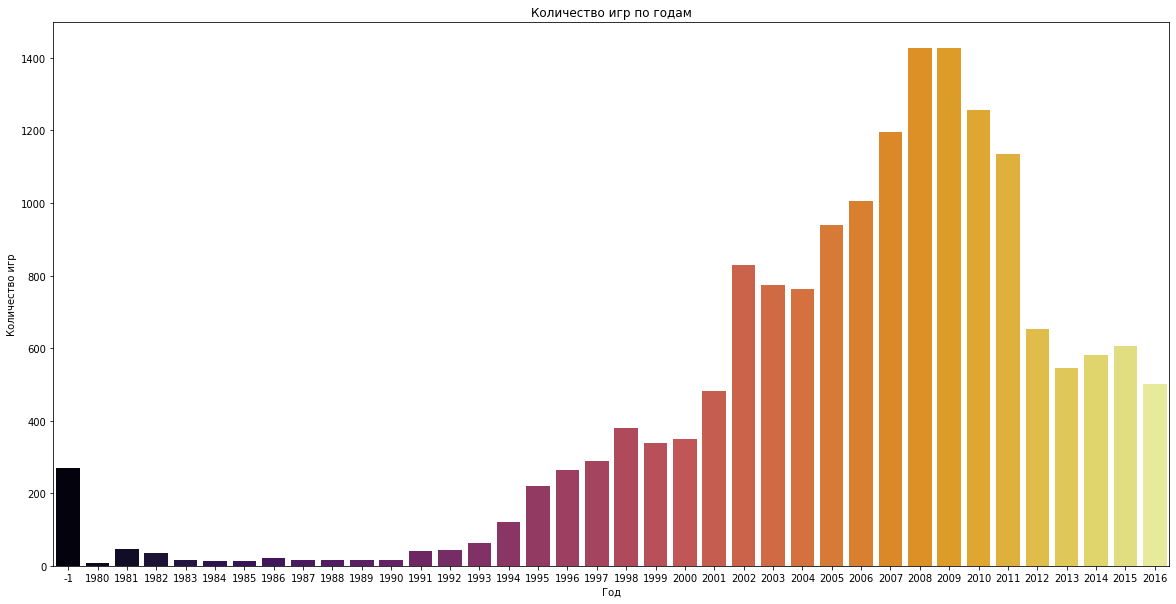

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=games_per_year.index, y="games_qty", data=games_per_year, palette="inferno")
ax.set_title("Количество игр по годам")
plt.xlabel('Год')
plt.ylabel('Количество игр');

Как видно из графика, рост количества игр в год начался с 1991 года, а пик пришёлся на 2008-2009 гг.
Период с 1980 по 1990 гг. не важен для нас, т.к. в этот период происходило зарождение игр и данных не так много.
Прогноз продаж нужен на 2017 год, поэтому этот период мы точно рассматривать не будем - слишком он старый.

- Посчитаем продажи игр по платформам и построим гистограмму.

In [17]:
platform_sales = df.pivot_table(index='platform', values='total_sales', aggfunc='sum')\
                .sort_values(by='total_sales', ascending=False)
platform_sales.columns = ['total_sales_platform']
platform_sales.reset_index().head(15)

,platform,total_sales_platform
0,PS2,1255.77
1,X360,971.42
2,PS3,939.65
3,Wii,907.51
4,DS,806.12
5,PS,730.86
6,GBA,317.85
7,PS4,314.14
8,PSP,294.05
9,PC,259.52


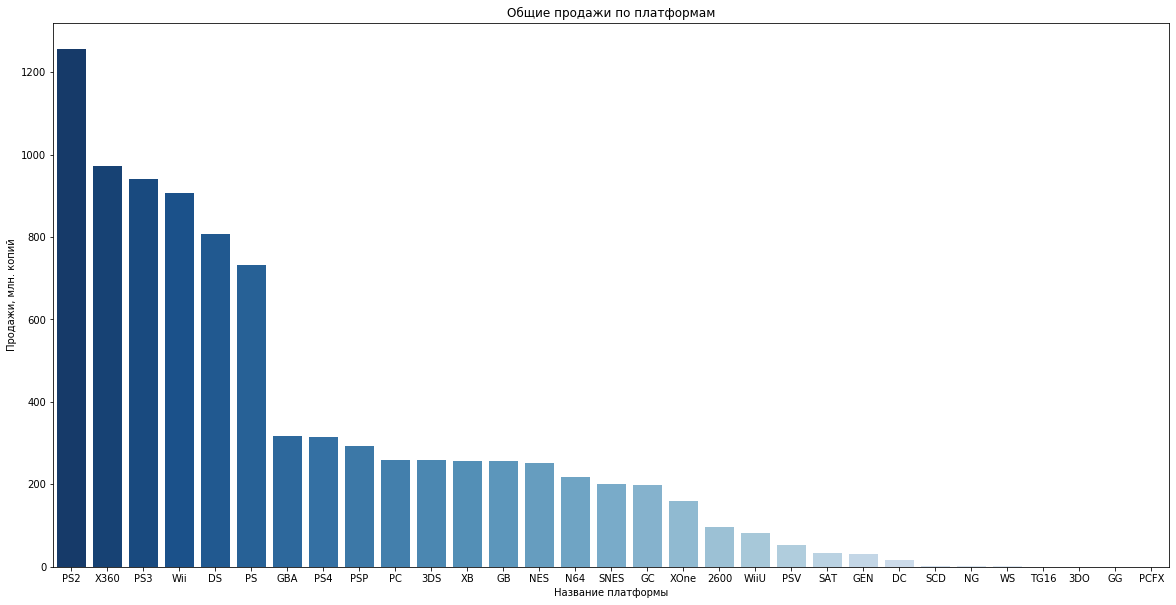

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=platform_sales.index, y="total_sales_platform", data=platform_sales, palette="Blues_r")
ax.set_title("Общие продажи по платформам")
plt.xlabel('Название платформы')
plt.ylabel('Продажи, млн. копий');

Лидирует платформа PS2.
Выберем топ-10 платформ с наибольшими суммарными продажами и построим распределение по годам. 
На необходимо определить жизненный цикл платформы.

In [19]:
top_platforms_list = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC',]

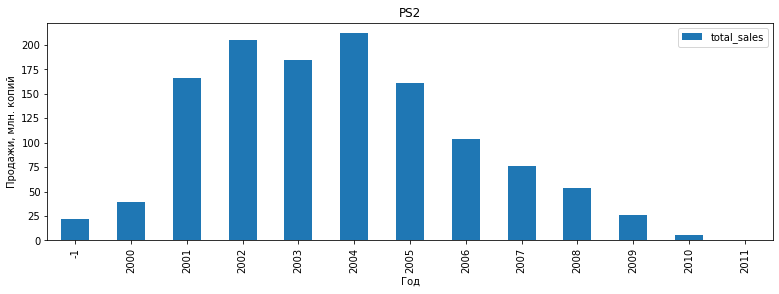

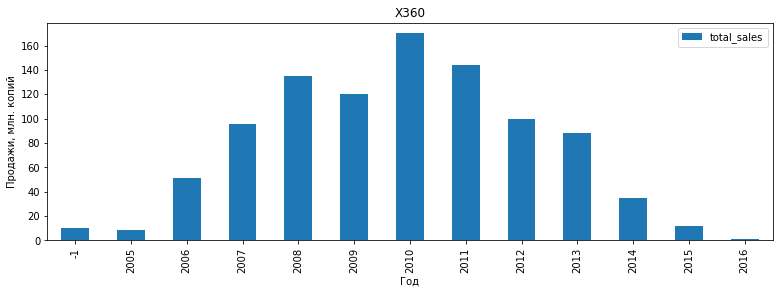

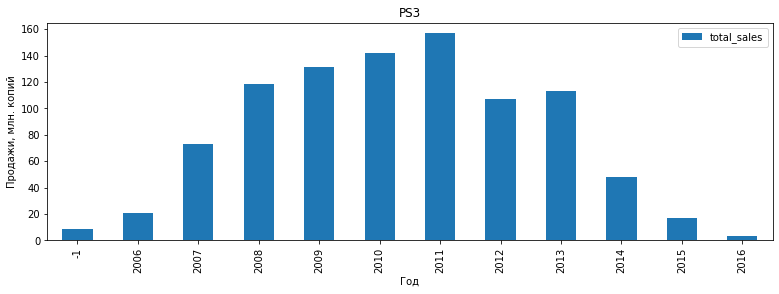

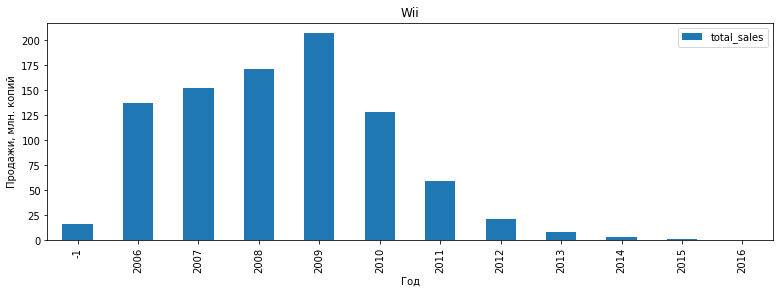

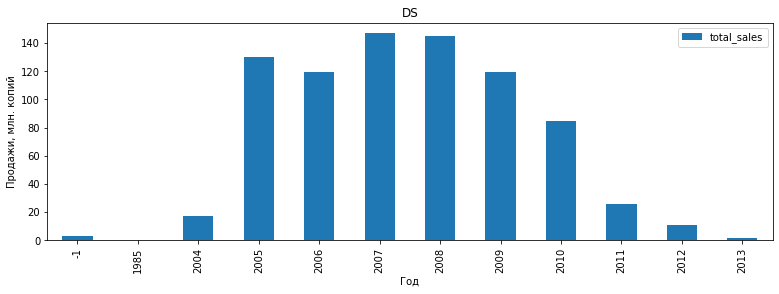

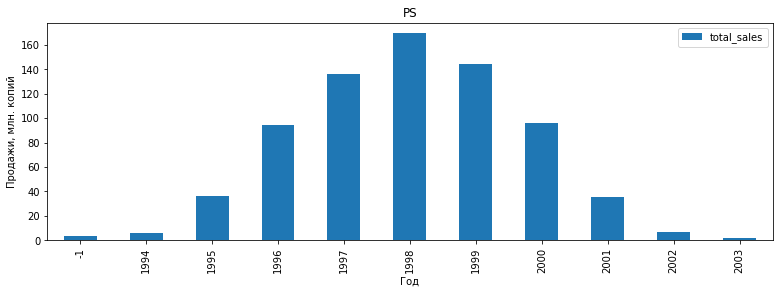

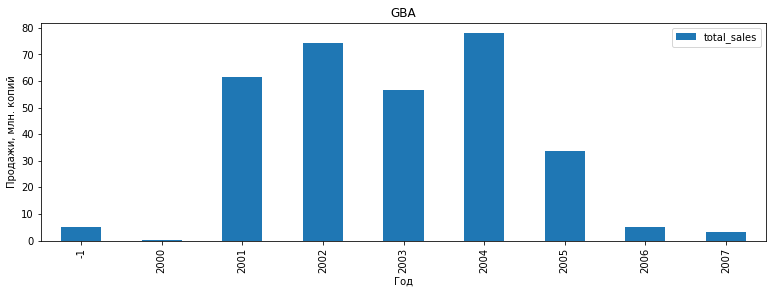

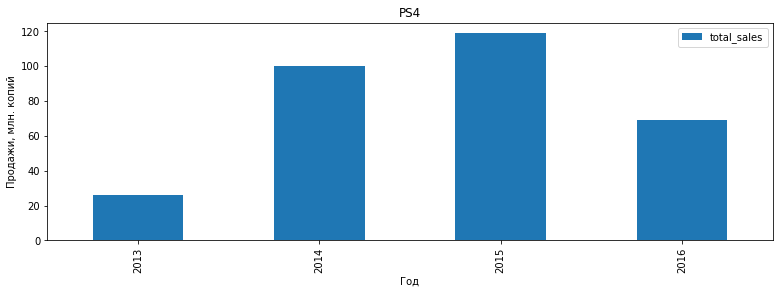

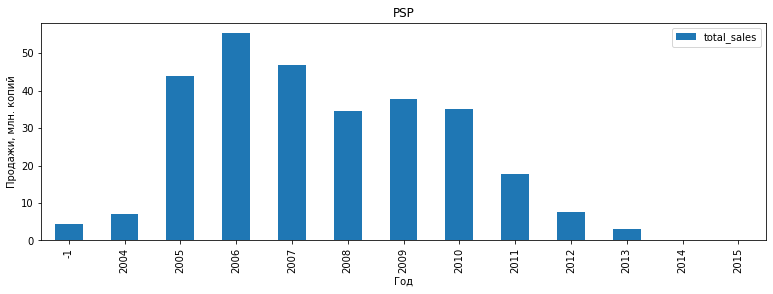

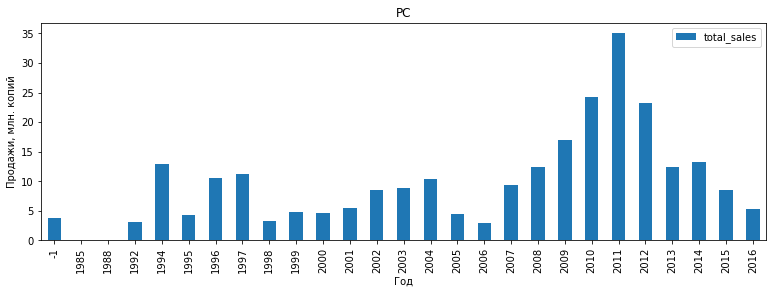

In [20]:
for platform in top_platforms_list:
    df[df['platform'] == platform].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(
        kind='bar', figsize=(13,4))
    plt.title(platform)
    plt.xlabel('Год')
    plt.ylabel('Продажи, млн. копий')

Лидер по продолжительности - PC. Начало в 1985 г. и до сих пор эта платформа актуальна.
Если взять среднюю продолжительность из этой выборки без PC и PS4 (зарождающаяся платформа), то примерный жизненный цикл - 11 лет.

Большинство платформ на 2016 год заканчивают свой жизненный цикл, поэтому прогноз на 2017 год будет не сильно оптимистичен.

- Выберем актуальный период - с 2012 года по 2016 год. Данные за этот период помогут нам построить прогноз на 2017 год.
Данные до 2012 года учитываться не будут.

Этот период выбран по нескольким причинам:
- мы отсекаем  платформы, на которых игры уже не выпускаются, и оставляем те, которые наиболее популярны в данный момент;
- период с 2001 по 2016 гг. был самым прибыльным для платформ, но не равномерным - до 2012 года был рост с небольшими коррекциями продаж, а начиная с 2012 года, резкое падение и далее примерно равные продажи по годам. Данные за 2016 год неполные, поэтому есть шанс даже на небольшой рост. Лучше отсечь сильный рост до 2012 года, т.к. предпосылок к значительному росту в 2016 и 2017 гг. нет. 

In [21]:
actual_period = df[df['year_of_release'] > 2011]
actual_period

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,-1,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,-1,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,-1,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,-1.0,-1.0,-1,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1.0,-1.0,-1,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,-1,0.01


In [22]:
actual_period.pivot_table(index='platform', values='total_sales', aggfunc='sum')\
                    .sort_values(by='total_sales', ascending=False).reset_index()

,platform,total_sales
0,PS4,314.14
1,PS3,288.79
2,X360,236.54
3,3DS,194.61
4,XOne,159.32
5,WiiU,82.19
6,PC,62.65
7,PSV,49.18
8,Wii,35.37
9,DS,12.55


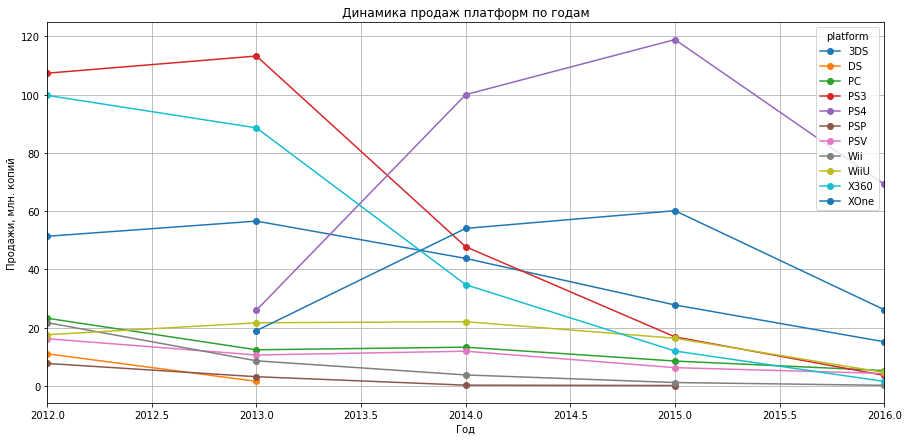

In [23]:
platform_sales = actual_period.pivot_table(
                index='year_of_release', columns ='platform', values='total_sales', aggfunc='sum')\
                .plot(figsize=(15,7), style='o-', grid=True, title='Динамика продаж платформ по годам')
platform_sales.set_xlabel("Год")
platform_sales.set_ylabel("Продажи, млн. копий");

In [24]:
actual_period.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')       

year_of_release,2012,2013,2014,2015,2016
platform,,,,,
3DS,51.36,56.57,43.76,27.78,15.14
DS,11.01,1.54,NaN,NaN,NaN
PC,23.22,12.38,13.28,8.52,5.25
PS3,107.36,113.25,47.76,16.82,3.60
PS4,NaN,25.99,100.00,118.90,69.25
PSP,7.69,3.14,0.24,0.12,NaN
PSV,16.19,10.59,11.90,6.25,4.25
Wii,21.71,8.59,3.75,1.14,0.18
WiiU,17.56,21.65,22.03,16.35,4.60


По продажам лидируют:
- PS4 - 314.14 млн. копий;
- PS3 - 288.79 млн. копий;
- X360 - 236.54 млн. копий;
- 3DS - 194.61 млн. копий;
- XOne - 159.32 млн. копий.

Все платформы падают, но это связано с тем, что данные за 2016 год - неполные.
Без данных за 2016 год рост наблюдается для платформ PS4 и XOne.
Потенциально прибыльные платформы - молодые платформы PS4 и XOne и один из лидеров 3DS.
При этом PS3 и X360 являются предыдущими моделями перед PS4 и XOne и их продажи в 2017 году будут стремиться к 0, исходя из динамики продаж по годам.

- Построим график «ящик с усами» по глобальным продажам игр в разбивке по потенциально прибыльным платформам.

In [25]:
best_platforms = ['PS4','XOne','3DS']

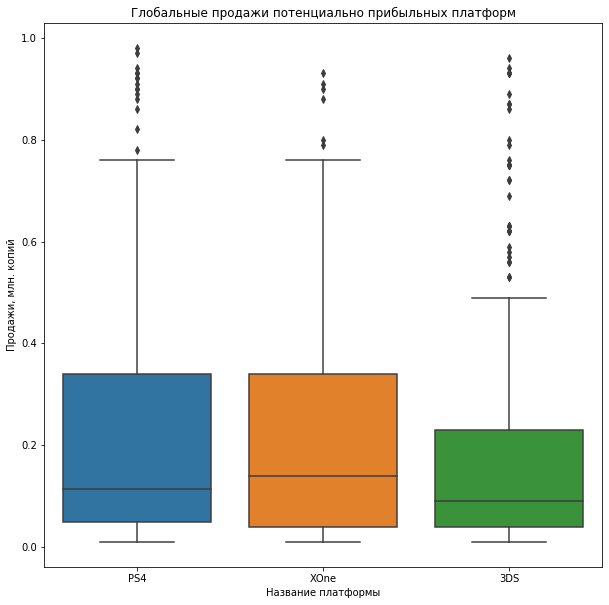

In [26]:
plt.figure(figsize=(10,10))
sns.boxplot(y='total_sales', x='platform',
            data = actual_period.query('platform in @best_platforms and total_sales < 1'),
            order=best_platforms
           )
plt.title("Глобальные продажи потенциально прибыльных платформ")
plt.xlabel('Название платформы')
plt.ylabel('Продажи, млн. копий')
plt.show()

На графиках видно, что платформа 3DS - наименее популярная среди пользователей, возможная причина - это японская платформа.
PS4 и XOne более популярны в мире, чем 3DS.
Разброс в продажах примерно одинаковое у PS4 и XOne, медианное значение тоже примерно на одном уровне, хоть и у XOne немного выше.
3DS примерно в 1,5-2 раза уступает конкурентам.

- Посмотрим, как влияют на продажи PS4 отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

Возьмём самую популярную и перспективную платформу за актуальный период - PS4, и отсечём строки, у которых не было оценок критиков и отзывов пользователей (с уникальным значением "-1"). 

In [27]:
sony_ps4 = actual_period[(actual_period['platform'] == 'PS4') & (actual_period['user_score'] != -1) \
                         & (actual_period['critic_score'] != -1)]
sony_ps4

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17
...,...,...,...,...,...,...,...,...,...,...,...,...
16486,Super Dungeon Bros,PS4,2016,Action,0.01,0.00,0.00,0.00,42.0,2.3,E10+,0.01
16499,Sherlock Holmes: The Devil's Daughter,PS4,2016,Adventure,0.01,0.00,0.00,0.00,70.0,6.8,T,0.01
16500,Root Letter,PS4,2016,Adventure,0.00,0.00,0.01,0.00,69.0,7.5,-1,0.01
16526,Dungeons 2,PS4,2016,Role-Playing,0.01,0.00,0.00,0.00,61.0,7.9,T,0.01


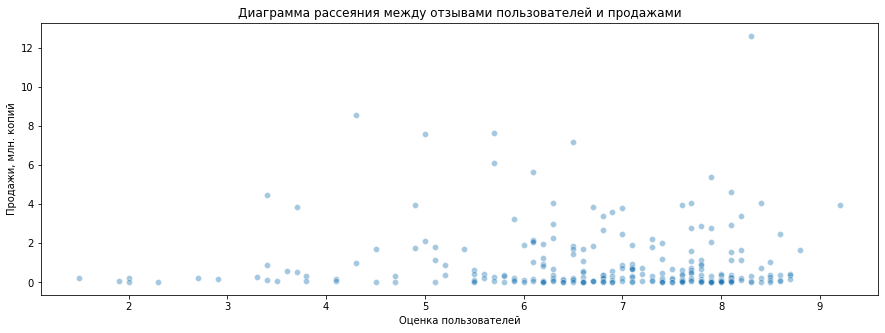

In [28]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='user_score', y='total_sales', data=sony_ps4, alpha=0.4)
plt.title('Диаграмма рассеяния между отзывами пользователей и продажами')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи, млн. копий');

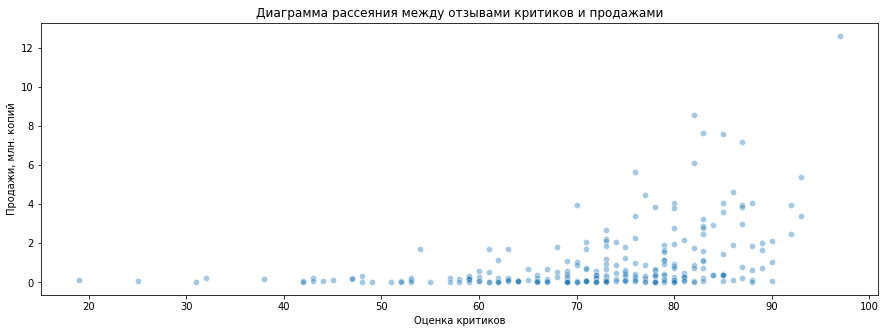

In [29]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='critic_score', y='total_sales', data=sony_ps4, alpha=0.4)
plt.title('Диаграмма рассеяния между отзывами критиков и продажами')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи, млн. копий');

Посчитаем корреляцию.

In [30]:
sony_ps4[['user_score', 'critic_score', 'total_sales']].corr()

,user_score,critic_score,total_sales
user_score,1.000000,0.557654,-0.033625
critic_score,0.557654,1.000000,0.405895
total_sales,-0.033625,0.405895,1.000000


Корреляция между оценкой пользователей и продажами достаточно слабая. Зато есть корреляция между оценкой критика и продажами - чем выше оценка, тем более прибыльные игры.

- Проверим этот вывод и на других платформах - XOne и 3DS.

In [31]:
xone = actual_period[(actual_period['platform'] == 'XOne') & (actual_period['user_score'] != -1) \
                         & (actual_period['critic_score'] != -1)]
_3ds = actual_period[(actual_period['platform'] == '3DS') & (actual_period['user_score'] != -1) \
                         & (actual_period['critic_score'] != -1)]

In [32]:
xone[['user_score', 'critic_score', 'total_sales']].corr()

,user_score,critic_score,total_sales
user_score,1.000000,0.472462,-0.094003
critic_score,0.472462,1.000000,0.410422
total_sales,-0.094003,0.410422,1.000000


In [33]:
_3ds[['user_score', 'critic_score', 'total_sales']].corr()

,user_score,critic_score,total_sales
user_score,1.000000,0.722762,0.201813
critic_score,0.722762,1.000000,0.310553
total_sales,0.201813,0.310553,1.000000


Корреляция для платформы отражает похожую зависимость продаж от оценки критиков и слабую корреляцию от оценки пользователей.
А вот у платформы 3DS ярко выражена корреляция между оценкой критиков и оценкой пользователей, но влияние на продажи не так значительно как у предыдущих платформ.

- Посмотрим на общее распределение игр по жанрам: сделаем сводную таблицу по жанрам, которая будет показывать количество игр в каждом жанре, их общие продажи и прибыльность на 1 игру.

In [34]:
genre_sales = actual_period.pivot_table(index='genre', values='total_sales', aggfunc=['count', 'sum']).reset_index()
genre_sales.columns = ['genre', 'game_qty', 'total_sales']
genre_sales['sales_per_game'] = genre_sales['total_sales'] / genre_sales['game_qty']
genre_sales.sort_values(by='sales_per_game', ascending=False)

,genre,game_qty,total_sales,sales_per_game
8,Shooter,235,304.73,1.296723
4,Platform,85,61.00,0.717647
10,Sports,268,181.07,0.675634
7,Role-Playing,370,192.80,0.521081
6,Racing,115,53.50,0.465217
3,Misc,192,85.04,0.442917
9,Simulation,80,35.12,0.439000
0,Action,1031,441.12,0.427856
2,Fighting,109,44.49,0.408165
11,Strategy,71,13.34,0.187887


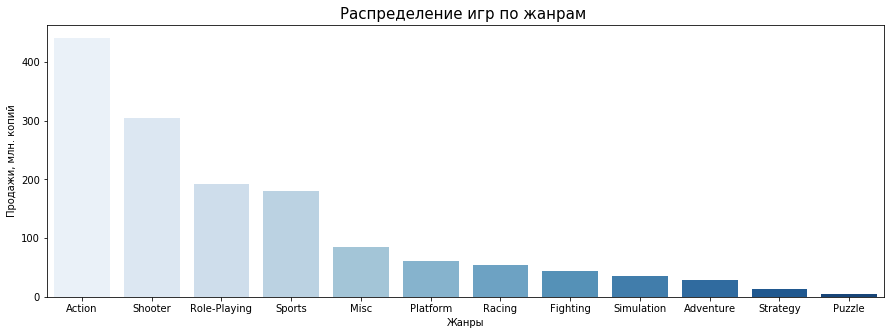

In [35]:
plt.figure(figsize=(15,5))
plt.title('Распределение игр по жанрам ',fontsize=15)
sns.barplot(data=genre_sales.sort_values(by='total_sales', ascending=False), x='genre', y='total_sales', palette='Blues')
plt.xlabel('Жанры')
plt.ylabel('Продажи, млн. копий');

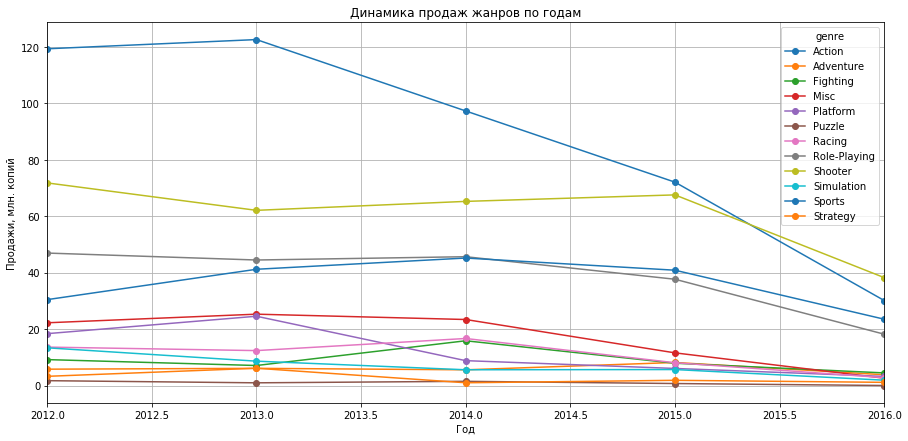

In [36]:
genre_sales_per = actual_period.pivot_table(index='year_of_release', columns ='genre', values='total_sales', aggfunc='sum')\
                .plot(figsize=(15,7), style='o-', grid=True, title='Динамика продаж жанров по годам');
genre_sales_per.set_xlabel("Год")
genre_sales_per.set_ylabel("Продажи, млн. копий");

Самые прибыльные жанры по суммарным продажам:
- Action - 441.12 млн. копий;
- Shooter - 304.73 млн. копий;
- Role-Playing - 192.80 млн. копий.
Лидирующий жанр падает по объёмам продаж с 2013  года, а другие жанры имеют равномерное распределение продаж по годам.

Жанры с самыми низкими суммарными продажами:
- Puzzle - 4.89 млн. копий;
- Strategy - 13.34 млн. копий;
- Adventure - 29.43 млн. копий.
Распределение по годам равномерное, с небольшой коррекцией вниз к 2016 году.

Но мы видим, что количество игр в каждом жанре неодинаковое, поэтому мы посчитали прибыльность на 1 игру.
Такой расчёт позволил нам выделить самый успешный жанр - Shooter, у которого прибыльность равна 1.3 млн. копий на игру, в то время как самый прибыльный жанр по общим продажам Action имеет прибыльность в 3 раза меньше - 0.43 млн. копий на игру.

### Вывод

В ходе данного шага был проведён исследовательский анализ и сделаны следующие выводы:
- До начала 90х гг. количество игр было небольшое, затем начался рост с пиком в 2008-2009 гг. Период до 90х гг. был сразу отсечён, т.к. это был период зарождения игровой сферы и количество данных небольшое.
- Анализ продаж по платформам показал абсолютных лидеров, было выделено топ-10 платформ. Дальнейший их анализ показал, что жизненный цикл платформ – около 11 лет.
- Мы выбрали актуальный период с 2012 года по 2016 год, что позволило нам отсечь старые и вышедшие из оборота платформы и срезать пики в продажах, т.к. в 2012 году произошло падение продаж и к 2016 году оно не восстановилось, но ожидается небольшой рост в 2016 году и, соответственно, в 2017 году.
- Анализ платформ в актуальном периоде позволил выделить лидеров и потенциально прибыльные платформы – PS4, XOne и 3DS. Нам, как интернет-магазину, который продаёт игры по всему миру важно охватить разные рынки. Эти три платформы позволяют это сделать.
- При этом большинство платформ за этот период падает, но есть надежда на растущие платформы PS4, XOne (продажи PS3 и X360 могут перейти в их продажи в 2016-2017 гг.).
- Анализ корреляций между продажами и отзывами юзеров и критиков показал, что есть умеренное влияние оценок критиков и слабое влияние отзывов пользователей.
- Общее распределение игр по жанрам показало, что самый популярный жанр Action, но его продажи с каждым годом падают и есть шанс, что в 2016-2017 гг. жанр Shooter его сместит. Все остальные жанры показывают примерно равномерное распределение по годам и можно ожидать такое же распределение в 2016-2017 гг.;
- Самый успешный жанр - Shooter: его прибыльность на 1 игру самая высокая среди всех жанров и равна 1.3 млн. копий.

## Составление портрета пользователя

Сделаем сводные таблицы с продажами в зависимости от платформы, жанра и рейтинга игр.

Рейтинг ESRB (США и Канада):
- «E» («Everyone») — «Для всех»;
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»;
- «T» («Teen») — «Подросткам;
- «M» («Mature») — «Для взрослых».

In [37]:
actual_period.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)\
.reset_index().head()

,platform,na_sales
0,X360,140.05
1,PS4,108.74
2,PS3,103.38
3,XOne,93.12
4,3DS,55.31


In [38]:
actual_period.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)\
.reset_index().head()

,platform,eu_sales
0,PS4,141.09
1,PS3,106.86
2,X360,74.52
3,XOne,51.59
4,3DS,42.64


In [39]:
actual_period.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)\
.reset_index().head()

,platform,jp_sales
0,3DS,87.79
1,PS3,35.29
2,PSV,21.04
3,PS4,15.96
4,WiiU,13.01


Топ-5 самых популярных платформ:
- в NA: X360, PS4, PS3, XOne, 3DS.
- в EU: PS4, PS3, X360, XOne, 3DS.
- в JP: 3DS, PS3, PSV, PS4, WiiU.

In [40]:
actual_period.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)\
.reset_index().head()

,genre,na_sales
0,Action,177.84
1,Shooter,144.77
2,Sports,81.53
3,Role-Playing,64.00
4,Misc,38.19


In [41]:
actual_period.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)\
.reset_index().head()

,genre,eu_sales
0,Action,159.34
1,Shooter,113.47
2,Sports,69.09
3,Role-Playing,48.53
4,Racing,27.29


In [42]:
actual_period.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)\
.reset_index().head()

,genre,jp_sales
0,Role-Playing,65.44
1,Action,52.80
2,Misc,12.86
3,Simulation,10.41
4,Fighting,9.44


Топ-5 самых популярных жанров:
- в NA: Action, Shooter, Sports, Role-Playing, Misc.
- в EU: Action, Shooter, Sports, Role-Playing, Racing.
- в JP: Role-Playing, Action, Misc, Simulation, Fighting.

In [43]:
actual_period.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)\
.reset_index()

,rating,na_sales
0,M,231.57
1,E,114.37
2,-1,103.31
3,E10+,75.70
4,T,66.02


In [44]:
actual_period.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)\
.reset_index()

,rating,eu_sales
0,M,193.96
1,E,113.03
2,-1,91.50
3,E10+,55.37
4,T,52.96


In [45]:
actual_period.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)\
.reset_index()

,rating,jp_sales
0,-1,108.84
1,E,28.33
2,T,26.02
3,M,21.20
4,E10+,8.19


По рейтингам видно, что:
- в NA больше всего продаж у игр с рейтингом "M" - "для взрослых", а затем идут игры с рейтингом "E" - "для всех".
- в EU больше всего продаж у игр с рейтингом "M" - "для взрослых", а затем идут игры с рейтингом "E" - "для всех".
- в JP больше всего продаж у игр без рейтинга (уникальное значение "-1"). Это говорит о том, что система ESRB не особо популярна в Японии и у них набор игр совершенно другой (без рейтинга ESRB). Думаю, что у них есть своя система рейтингов. Далее идут игры с рейтингом "E" - "для всех".

Самые популярные платформы (топ-5) в NA и EU одинаковые, но различается только их порядок и объёмы. Это объясняется тем, что вкус американцев и европейцев совпадают (они больше похожи между собой, чем с японцами).
Японцы поддерживают японских производителей и в списке популярных платформ у них нет ни одной, связанной с Microsoft.

Такая же ситуация с жанрами - американцы и европейцы почти совпадают по вкусам, а вот японцы выделяются экзотикой - Simulation и Fighting.

Системы рейтингов в NA и EU могут быть одинаковыми, а вот в Японии совсем другие правила - большинство популярных игр без рейтинга ESRB. На непопулярные игры в NA и EU рейтинг вряд ли будут проставлять.

### Вывод

На данном шаге мы составили портрет пользователя каждого региона на основе данных по продажам в зависимости от платформы, жанра и рейтинга ESRB.
Был сделан вывод, что пользователи NA и EU почти совпадают по вкусам в выборе платформы и жанра, а также игры с одинаковыми рейтингами ("M" - "для взрослых" и "E" - "для всех") лидируют по продажам. Это можно ообъяснить тем, что такие рейтинги позволяют охватить наибольшую аудиторию пользователей.

Вкусы пользователей из JP кардинально отличаются от NA и EU - они поддерживают только японских производителей платформ, их интересуют другие жанры и большинство игр без рейтинга ESRB, который был придуман в Северной Америке.

## Проверка гипотез

Нам необходимо проверить гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
Нулевая и альтернативная гипотезы звучат так:

    H₀ - средние пользовательские рейтинги платформ Xbox One и PC равны.
    H₁ - средние пользовательские рейтинги платформ Xbox One и PC различаются.

H₀ всегда формулируется так, чтобы использовать знак равенства. Пороговое значение alpha равно 0.05.

In [46]:
xbox_one = actual_period.query('platform == "XOne" and user_score != -1')['user_score']
pc = actual_period.query('platform == "PC" and user_score != -1')['user_score']

alpha = 0.05

results = st.ttest_ind(
    xbox_one, 
    pc, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


In [47]:
xbox_one_pc = actual_period.query('(platform == "XOne" and user_score != -1) or (platform == "PC" and user_score != -1)')
xbox_one_pc.pivot_table(index='platform', values='user_score', aggfunc=['count', 'mean', 'median'])

,count,mean,median
,user_score,user_score,user_score
platform,,,
PC,206,6.428641,6.8
XOne,182,6.521429,6.8


Полученное значение p-value говорит о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Мы не отвергаем нулевую гипотезу. Чтобы её подтвердить, можно посмотреть среднее и медианное значения рейтинга в зависимости от платформы. Как мы видим, они почти равны.

Нам необходимо проверить гипотезу о том, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
Нулевая и альтернативная гипотезы звучат так:

    H₀ - средние пользовательские рейтинги жанров Action и Sports равны.
    H₁ - средние пользовательские рейтинги жанров Action и Sports различаются.

H₀ всегда формулируется так, чтобы использовать знак равенства. Пороговое значение alpha равно 0.05.

In [48]:
action = actual_period.query('genre == "Action" and user_score != -1')['user_score']
sport = actual_period.query('genre == "Sports" and user_score != -1')['user_score']

alpha = 0.05

results = st.ttest_ind(
    action, 
    sport, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


In [49]:
action_sport = actual_period.query('(genre == "Action" and user_score != -1) or (genre == "Sports" and user_score != -1)')
action_sport.pivot_table(index='genre', values='user_score', aggfunc=['count', 'mean', 'median'])

,count,mean,median
,user_score,user_score,user_score
genre,,,
Action,523,6.825048,7.1
Sports,195,5.455897,5.7


Полученное значение p-value говорит о том, что средние пользовательские рейтинги жанров Action и Sports не равны. Мы отвергаем нулевую гипотезу.
Чтобы проверить верность нашего решения, можно посмотреть среднее и медианное значения выручки в зависимости от тарифа. Как мы видим, они достаточно сильно различаются.

### Вывод

В результате проверки двух гипотез можно сделать следующие выводы:

1) средние пользовательские рейтинги платформ Xbox One и PC одинаковые, что подтверждается средним и медианным значениями. Нам не удалось отвергнуть нулевую гипотезу.

2) средние пользовательские рейтинги жанров Action и Sports не равны, что подтверждается средним и медианным значениями. Была отвергнуть нулевая гипотеза.

Для оценки был использован уровень статистической значимости критерия Стьюдента для независимых выборок. В данном случае критерий задан значением 0.05.

## Общий вывод

В ходе данного исследования были сделаны следующие шаги и выводы:

1) предварительный анализ показал проблемы, которые необходимо было решить на втором шаге:
- необходимость привести к нижнему регистру названия в столбцах;
- есть пропуски в разных столбцах. Большое количество пропусков (более 40%) в столбцах 'critic_score', 'user_score' и 'rating' удалить нельзя и нужно будет сделать замену на уникальное значение;
- необходимость изменить тип данных в столбцах 'year_of_release' и 'user_score' для удобства дальнейшего использования.

2) на этапе предобработки данных:
- были приведены названия столбцов к нижнему регистру и изменены типы данных;
- пропуски в столбцах были заполнены уникальными значениями “нет данных” и “-1”, т.к. нет данных, чтобы их корректно заполнить;
- далее был создан новый столбец с общими продажами по каждой игре.

3) в ходе исследовательского анализа данных были сделаны следующие выводы:
- до начала 90х гг. количество игр было небольшое, затем начался рост с пиком в 2008-2009 гг. Период до 90х гг. был сразу отсечён, т.к. это был период зарождения игровой сферы и количество данных небольшое;
- анализ продаж по платформам на основе топ-10 платформ показал, что жизненный цикл платформ – около 11 лет;
- был выбран актуальный период с 2012 года по 2016 год, который отсекает старые и вышедшие из оборота платформы и срезает пики в продажах. Это позволит более реалистично спрогнозировать продажи на 2017 год;
- анализ платформ показал лидеров и потенциально прибыльные платформы – PS4, XOne и 3DS;
- в большинстве случае продажи платформ за актуальный период падают, но есть надежда на растущие платформы PS4, XOne (продажи PS3 и X360 могут перейти в их продажи в 2016-2017 гг.);
- анализ корреляций между продажами и отзывами юзеров и критиков показал, что есть умеренное влияние оценок критиков и слабое влияние отзывов пользователей;
- самый популярный жанр на данный период - Action, но его продажи с каждым годом падают и есть шанс, что в 2016-2017 гг. жанр Shooter его сместит. Все остальные жанры показывают примерно равномерное распределение по годам и можно ожидать такое же распределение в 2016-2017 гг.;
- также вы выявили, что самый успешный жанр - Shooter: его прибыльность на 1 игру самая высокая среди всех жанров и равна 1.3 млн. копий.

4) на данном шаге мы составили портрет пользователя каждого региона на основе данных по продажам в зависимости от платформы, жанра и рейтинга ESRB. Был сделан вывод, что пользователи NA и EU почти совпадают по вкусам в выборе платформы и жанра, а также игры с одинаковыми рейтингами ("M" - "для взрослых" и "E" - "для всех") лидируют по продажам. Это можно ообъяснить тем, что такие рейтинги позволяют охватить наибольшую аудиторию пользователей.
Вкусы пользователей из JP кардинально отличаются от NA и EU - они поддерживают только японских производителей платформ, их интересуют другие жанры и большинство игр без рейтинга ESRB, который был придуман в Северной Америке.

5) Проводя статистический анализа мы проверили две гипотезы с уровнем значимости =0.05 :
- средние пользовательские рейтинги платформ Xbox One и PC одинаковые, что подтверждается средним и медианным значениями. Нам не удалось отвергнуть нулевую гипотезу.
- средние пользовательские рейтинги жанров Action и Sports не равны, что подтверждается средним и медианным значениями. Была отвергнуть нулевая гипотеза.
- для оценки был использован уровень статистической значимости критерия Стьюдента для независимых выборок. 

Исходя из полученных данных, нам, как интернет-магазину, который продаёт игры по всему миру важно охватить разные рынки. Наиболее перспективные платформы – PS4, XOne и 3DS, позволят это сделать. Но нужно учитывать, что предпочтения японцев отличаются от американцев и европейцев. Важна вариативность, но с соблюдением баланса.